# Agrammatic and paragrammatic aphasias

### Set-up

In [222]:
import random
import numpy as np
from copy import deepcopy
from importlib import reload 

import syntactic_wm as cjn ## Our model
reload(cjn)

################
## Parameters ##
################
num_steps = 5 # number of time steps taken by each word input.
head = 1 # number of time steps buffering the front of each sentence.
tail = 20 # number of time steps buffering the end of each sentence.
no_periods = 1 # number of epochs each sentence is presented to the model.

lambda_cc = 20 # learning rate of short-term synaptic plasticity amongst role neurons.
lambda_cf = 1 # learning rate of short-term synaptic plasticity between role and word neurons.

tau = 0.5 # modifies change in firing rate at each time step to simulate continuous time.

beta = 1.65 # decay factor of firing rates.

n_word_neurons = 15 # number of word neurons initialised (f)
n_role_neurons = 10 # number of role neurons initialised (c)

gamma = 0.5 # factor dampening connectivity amongst role neurons.

epsilon_cc = 9 # the ceiling of c-c connections when without long-term encoding, while taking into account of negative bias k. 
k_cc = 8 # negative bias, i.e. negative k_cc is the floor of c-c connections.

epsilon_cf = 3 # the ceiling of c-f connections when without long-term encoding, while taking into account of negative bias k. 
k_cf = 0 # negative bias, i.e. negative k_cf is the floor of c-f connections.

h = 7.5 # normalising factor for inhibition between c-f connections.

W_mc = 5.6 # connectivity between morph and role neurons (non-encodable)
W_mm = -10 # conneectivity between morpheme neurons to itself (non-encodable)

W_ff = -1.5  # connectivity amongst word neurons (non-encodable)

unified_noise = 0 # noise level if noise is present
cc_noise = False # any noise amongst role neurons
wc_noise = False # any noise between role and word neurons

k_L_cc = 16.5 # long-term encoding amongst role neurons 
k_L_cf = 1.6 # long-term encoding between role and word neurons

k_L_cf_closed_class = 1.7 # long-term encoding between role and word neurons when the word belongs to a closed class

auto_gramm = True # this flag moves the direct sensory input alpha to within the sigmoid function

# Flag to induce lesion in paragrammatic aphasia
wernic = False # flag that introduces noise into long-term encoding between word and role neurons. It will also switch lambda_cf to zero.

seed_ = 0 # setting default random seed
np.random.seed(seed_)
random.seed(seed_)

## Control (Sequential input)

First, we test that the model (with the current settings) can recall successfully with sequential input. <br>
Note two words are defined to be closed-class words.

In [2]:
LT_wc_knowledge = [[0,0],[1,0],[2,1],[3,1],[4,2],[5,2],[6,3],[7,4],[8,4],[9,5],[10,5],[11,6],[12,7],[13,7]] # long term encodings of word-to-role connections
LT_cc_knowledge = [[0,1,2,3,4],[0,1,5,6,7]] # long term encodings amongst role neurons
closed_class_word_roles = [[6,3],[11,6]] # define the closed class words

# building the sentence
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(num_steps): sentence.append(cjn.in_in(word=10))
for n in range(num_steps): sentence.append(cjn.in_in(word=11))
for n in range(num_steps): sentence.append(cjn.in_in(word=13))
for n in range(tail): sentence.append(cjn.in_in())

## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc - k_cc,
                       cf_max_connection = epsilon_cf - k_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       closed_class_learnt_weight = k_L_cf_closed_class,
                       closed_class_word_roles = closed_class_word_roles,
                       auto_gramm = auto_gramm,
                       wernic = wernic
                      )


# running the encoding phase
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  46
********************


### Visualisation of encoding

Again, we can visualise the learning that occurred during the encoding phase. <br>

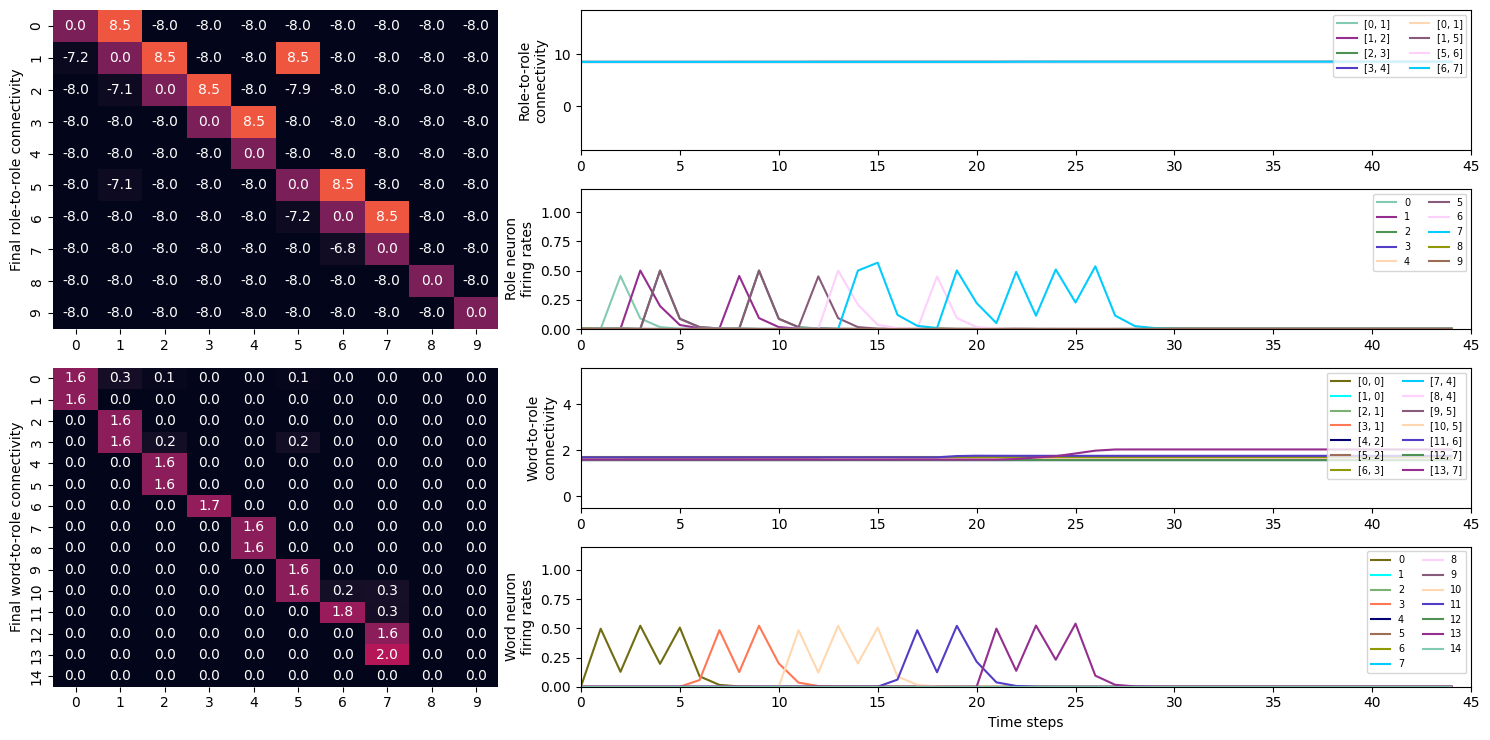

In [3]:
cjn.plot_results(sentence, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx)


### Recall of the encoded sentence

We test that the network is able to recall the above encoded sentence.

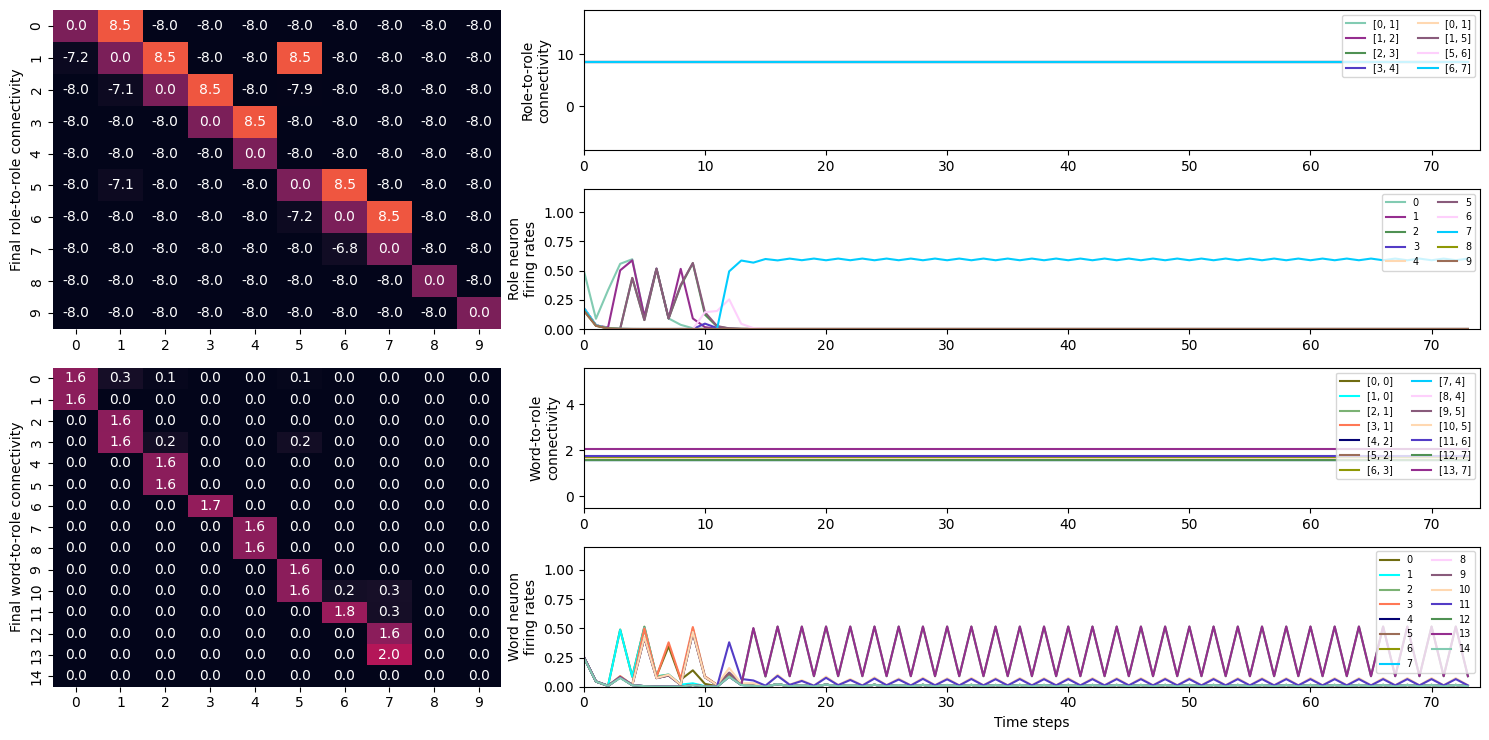

The final recall output is: 
[[0.0], [3.0], [10.0], [11.0], [13.0]]


In [4]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 75 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

## Control (with auto-serialization)

Next, we demonstrate that the network can produce grammatical output when the input includes simultaneous input demonstrating auto-serialisation, and also the exclusion of closed-class word in the input.

In [5]:
LT_wc_knowledge = [[0,0],[1,0],[2,1],[3,1],[4,2],[5,2],[6,3],[7,4],[8,4],[9,5],[10,5],[11,6],[12,7],[13,7]] # long term encodings of word-to-role connections
LT_cc_knowledge = [[0,1,2,3,4],[0,1,5,6,7]] # long term encodings amongst role neurons
closed_class_word_roles = [[6,3],[11,6]] # define the closed class words

# building the sentence
# note the closed class word is missing in this input
# feel free to try with different words and branching as defined by the long-term encodings!!
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(20): sentence.append([cjn.in_in(word=10),cjn.in_in(word=13)]) # simultaneous input fo two different words
for n in range(tail): sentence.append(cjn.in_in())

## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc - k_cc,
                       cf_max_connection = epsilon_cf - k_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       closed_class_learnt_weight = k_L_cf_closed_class,
                       closed_class_word_roles = closed_class_word_roles,
                       auto_gramm = auto_gramm
                      )


# running the encoding phase
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  51
********************


### Visualisation of encoding

We can visualise the learning that occurred during the encoding phase. <br>
In particular, we note that there is serialisation due to the sensory direct input $\alpha$ is being shifted into the $\sigma$ function.

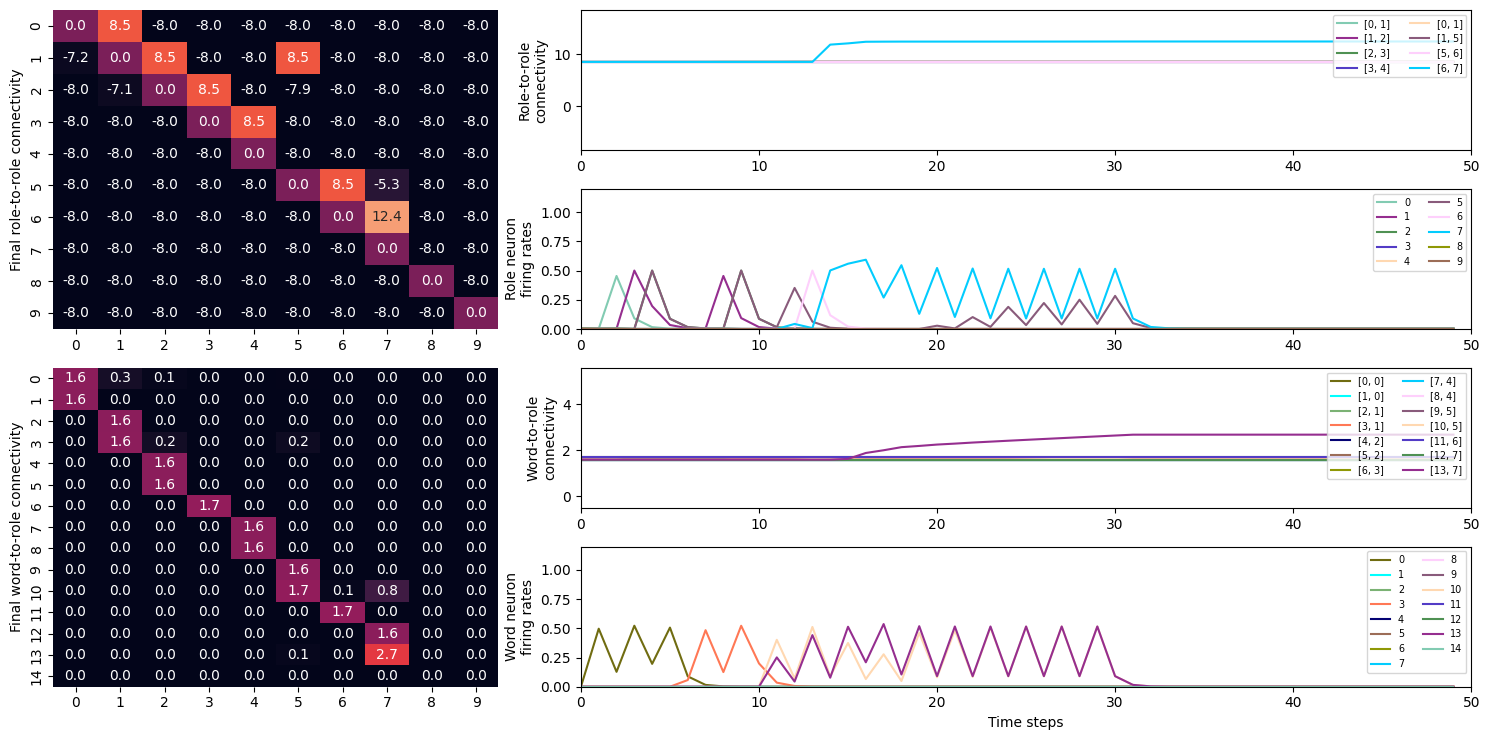

In [6]:
cjn.plot_results(sentence, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx)


### Recall of the encoded sentence with serialisation

We test that the network is able to recall the above encoded sentence with the serialisation and the missing closed-class word.

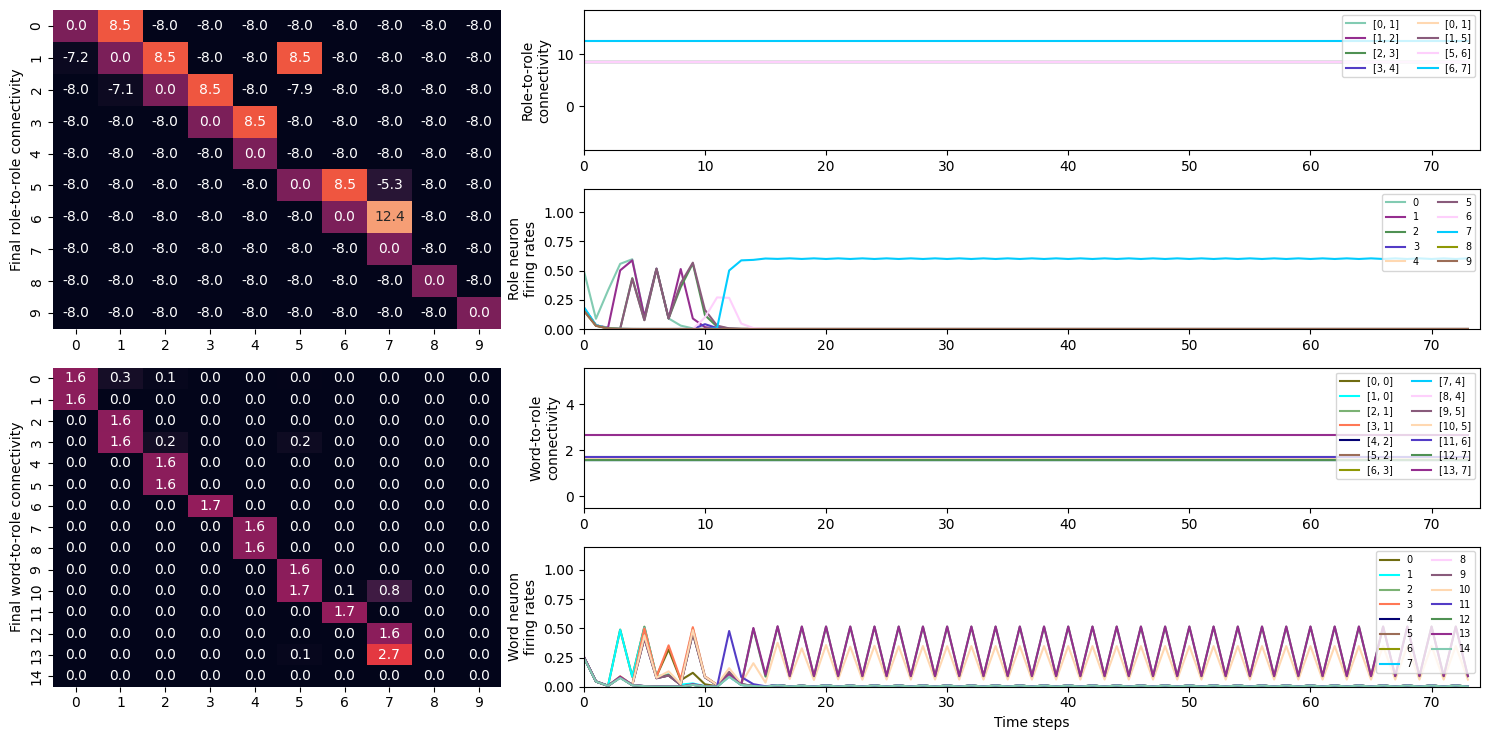

The final recall output is: 
[[0.0], [3.0], [10.0], [11.0], [13.0]]


In [7]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 75 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

### Demonstrate agrammatic aphasia

Following the control simulation above, we demonstrate that with the introduction of noise, the network produces recall similar to agrammatic aphasia.

In [226]:
LT_wc_knowledge = [[0,0],[1,0],[2,1],[3,1],[4,2],[5,2],[6,3],[7,4],[8,4],[9,5],[10,5],[11,6],[12,7],[13,7]] # long term encodings of word-to-role connections
LT_cc_knowledge = [[0,1,2,3,4],[0,1,5,6,7]] # long term encodings amongst role neurons
closed_class_word_roles = [[6,3],[11,6]] # define the closed class words

wernic = False

seed_ = 0 # setting default random seed
np.random.seed(seed_)
random.seed(seed_)
## adding noise to simulate agrammatic aphasia
unified_noise = 0.33
cc_noise = True
wc_noise = False
mw_noise = False

# building the sentence
# note the closed class word is missing in this input
# feel free to try with different words and branching as defined by the long-term encodings!!
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(20): sentence.append([cjn.in_in(word=10),cjn.in_in(word=13)]) # simultaneous input fo two different words
for n in range(tail): sentence.append(cjn.in_in())

## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc - k_cc,
                       cf_max_connection = epsilon_cf - k_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       closed_class_learnt_weight = k_L_cf_closed_class,
                       closed_class_word_roles = closed_class_word_roles,
                       auto_gramm = auto_gramm
                      )


# running the encoding phase
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  51
********************


### Visualisation of encoding

Again, we can visualise the learning that occurred during the encoding phase. <br>

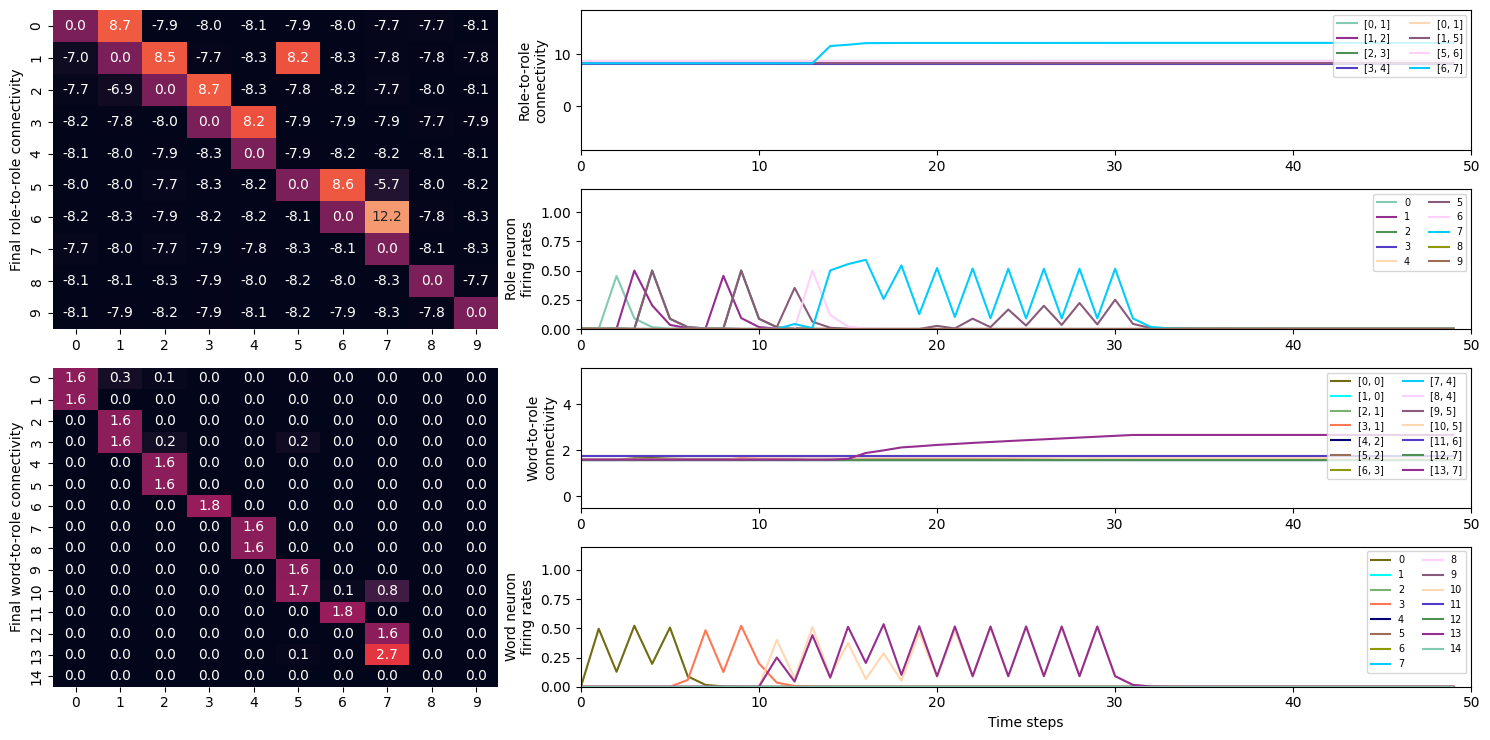

In [227]:
cjn.plot_results(sentence, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx)


### Recall of the encoded sentence showing agrammatic aphasia

The recalled sentence is missing the closed-class word while retaining the ability to serialise semantic input.

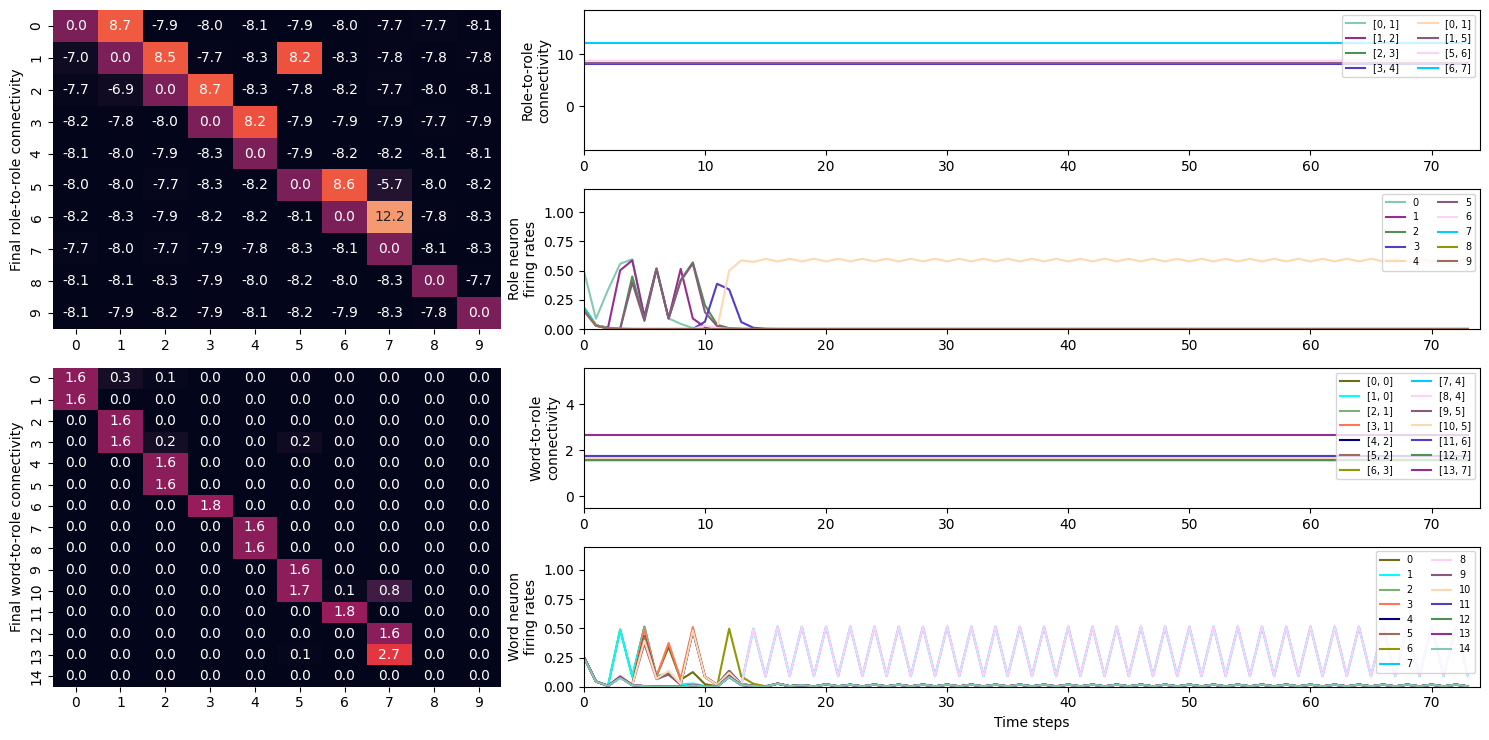

The final recall output is: 
[[0.0], [3.0], [-1.0], [6.0], [-1.0]]


In [228]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 75 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

## Paragrammatic aphasia

In the next simulation, we demonstrate that with the introduction of noise and switching of $\lambda^{fc}$ to 0, the network produces recall similar to paragrammtic aphasia. <br>
The sentence input is the same as in agrammatic aphasia above (i.e. with auto-serialization and exclusion of closed-class words)

In [20]:
LT_wc_knowledge = [[0,0],[1,0],[2,1],[3,1],[4,2],[5,2],[6,3],[7,4],[8,4],[9,5],[10,5],[11,6],[12,7],[13,7]] # long term encodings of word-to-role connections
LT_cc_knowledge = [[0,1,2,3,4],[0,1,5,6,7]] # long term encodings amongst role neurons
closed_class_word_roles = [[6,3],[11,6]] # define the closed class words

wernic = True # flag that introduces noise into long-term encoding between word and role neurons. It will also switch lambda_cf to zero.

# turning off the noise that was turned on for agrammatic aphasia
unified_noise = 0
cc_noise = False
wc_noise = False
mw_noise = False


# Different seeds will produce different recall output!
seed_ = 0 # setting default random seed
np.random.seed(seed_)
random.seed(seed_)

# building the sentence
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(20): sentence.append([cjn.in_in(word=10),cjn.in_in(word=13)]) # simultaneous input fo two different words
for n in range(tail): sentence.append(cjn.in_in())

## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc - k_cc,
                       cf_max_connection = epsilon_cf - k_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       closed_class_learnt_weight = k_L_cf_closed_class,
                       closed_class_word_roles = closed_class_word_roles,
                       auto_gramm = auto_gramm,
                       wernic = wernic
                      )


# running the encoding phase
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  51
********************


### Visualisation of encoding

We can visualise the learning that occurred during the encoding phase. <br>

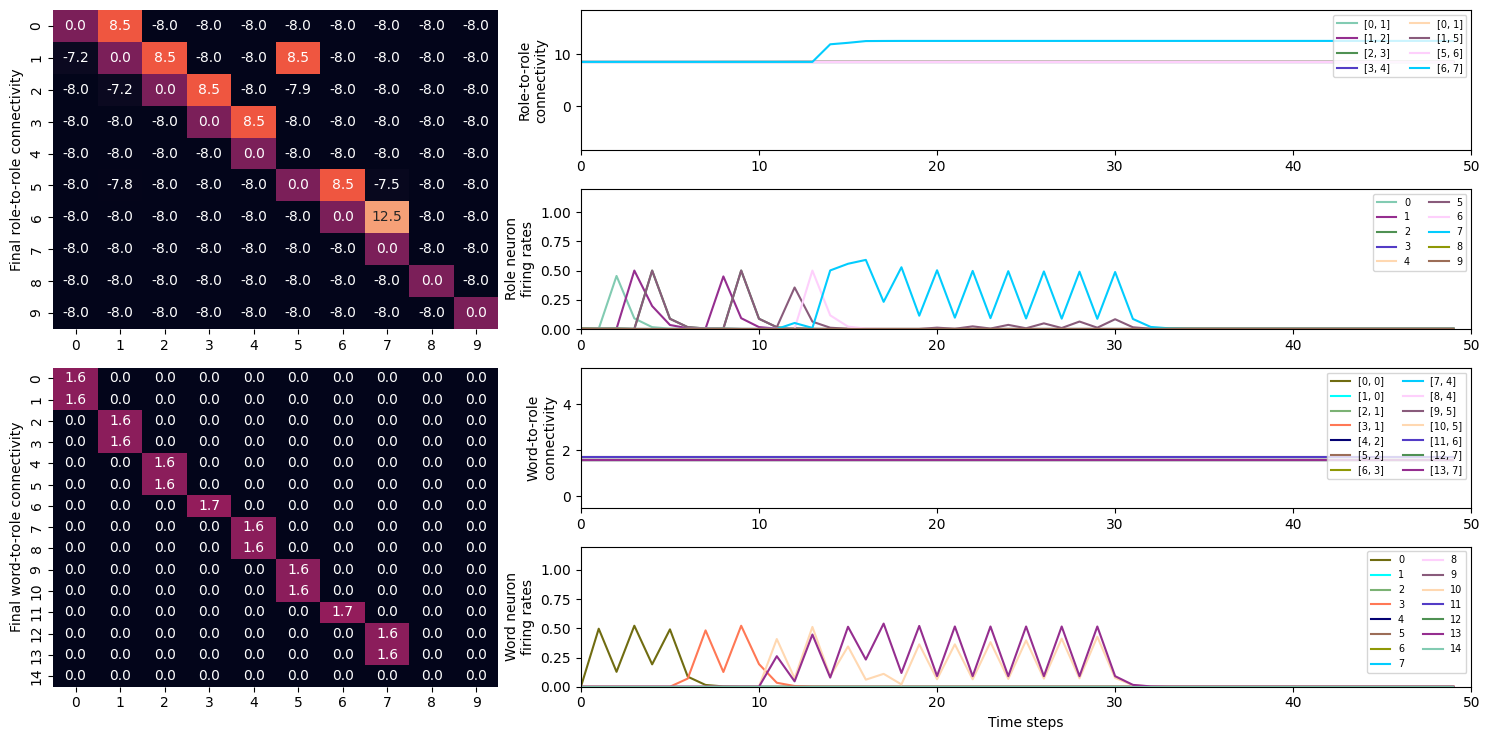

In [21]:
cjn.plot_results(sentence, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx)


### Recall of the encoded sentence showing paragrammatic aphasia

The recalled sentence has preserved syntax but missing original words in the input sentence. <br>
Trying different random seeds will give rise to different results.

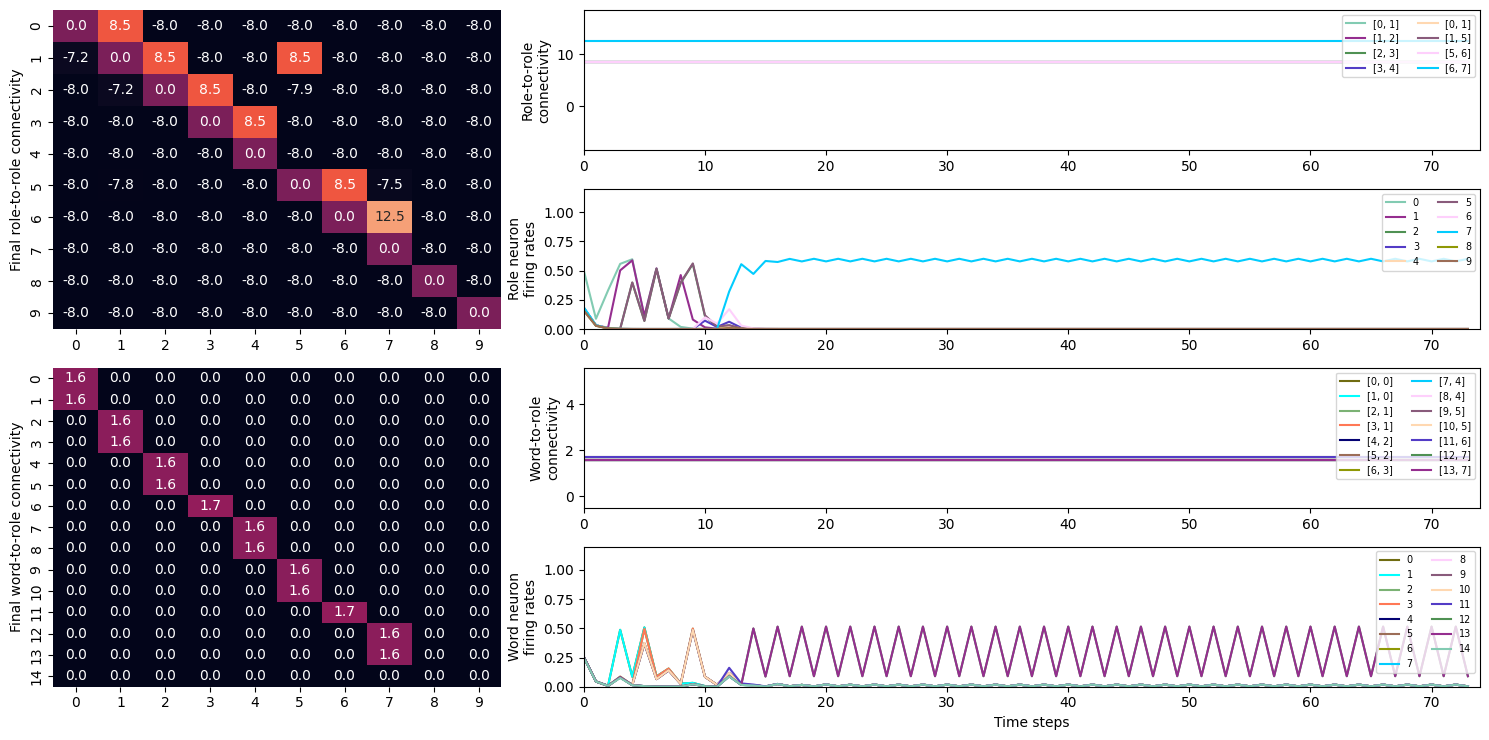

The final recall output is: 
[[1.0], [2.0], [10.0], [11.0], [13.0]]


In [22]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 75 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

In [242]:
LT_wc_knowledge = [[0,0],[1,0],[2,1],[3,1],[4,2],[5,2],[6,3],[7,4],[8,4],[9,5],[10,5],[11,6],[12,7],[13,7]] # long term encodings of word-to-role connections
LT_cc_knowledge = [[0,1,2,3,4],[0,1,5,6,7]] # long term encodings amongst role neurons
closed_class_word_roles = [[6,3],[11,6]] # define the closed class words

# building the sentence
# note the closed class word is missing in this input
# feel free to try with different words and branching as defined by the long-term encodings!!
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(20): sentence.append([cjn.in_in(word=10),cjn.in_in(word=13)]) # simultaneous input fo two different words
for n in range(tail): sentence.append(cjn.in_in())




for seed_ in range(50):
    print('#'*30)
    print('current seed is ' + str(seed_))

    np.random.seed(seed_)
    random.seed(seed_)

    wernic = True

    ## adding noise to simulate agrammatic aphasia
    unified_noise = 0
    cc_noise = False
    wc_noise = False
    mw_noise = False


    ## initialising the working memory model
    WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                           cc_connectivity_factor = gamma,
                           activation_decay = beta,
                           LR_c = lambda_cc,
                           LR_w = lambda_cf,
                           cc_max_connection = epsilon_cc - k_cc,
                           cf_max_connection = epsilon_cf - k_cf,
                           n_word_neurons = n_word_neurons,
                           time_factor = tau,
                           LT_wc_knowledge = LT_wc_knowledge,
                           cc_learnt_weight = k_L_cc - k_cc,
                           cf_learnt_weight = k_L_cf - k_cf,
                           input_node_connectivity = W_ff,
                           LT_cc_knowledge = LT_cc_knowledge,
                           cc_floor_weight = -k_cc, 
                           cf_floor_weight = -k_cf,
                           unified_noise = unified_noise,
                           cc_noise = cc_noise,
                           wc_noise = wc_noise,
                           cf_conj_factor = h,
                           mc_connectivity_factor = W_mc,
                           mm_connectivity_factor = W_mm,
                           closed_class_learnt_weight = k_L_cf_closed_class,
                           closed_class_word_roles = closed_class_word_roles,
                           auto_gramm = auto_gramm,
                           wernic = wernic
                          )


    # running the encoding phase
    role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)

    
    WM_r = deepcopy(WM_ori) # copy the encoded model
    initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
    n_steps = 75 # total number of time steps taken during recall

    # building recall input with 5 initial time steps with input into the first role neuron and then no further input.
    recall_input = []
    for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
    for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

    # running the recall phase
    cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

    # Final recall determined by argmax at each time step
    print('The final recall output is: ')
    print(cjn.argmax_sentence(f_act_hx_r))

##############################
current seed is 0
********************
Epoch = 1
Number of recorded time steps:  51
********************
The final recall output is: 
[[1.0], [2.0], [10.0], [11.0], [13.0]]
##############################
current seed is 1
********************
Epoch = 1
Number of recorded time steps:  51
********************
The final recall output is: 
[[1.0], [3.0], [9.0], [11.0], [13.0]]
##############################
current seed is 2
********************
Epoch = 1
Number of recorded time steps:  51
********************
The final recall output is: 
[[0.0], [2.0], [10.0], [11.0], [13.0]]
##############################
current seed is 3
********************
Epoch = 1
Number of recorded time steps:  51
********************
The final recall output is: 
[[1.0], [3.0], [5.0], [6.0], [7.0], [12.0]]
##############################
current seed is 4
********************
Epoch = 1
Number of recorded time steps:  51
********************
The final recall output is: 
[[0.0], [2.0], 

### Agrammatic aphasia outputs

In [243]:
LT_wc_knowledge = [[0,0],[1,0],[2,1],[3,1],[4,2],[5,2],[6,3],[7,4],[8,4],[9,5],[10,5],[11,6],[12,7],[13,7]] # long term encodings of word-to-role connections
LT_cc_knowledge = [[0,1,2,3,4],[0,1,5,6,7]] # long term encodings amongst role neurons
closed_class_word_roles = [[6,3],[11,6]] # define the closed class words

# building the sentence
# note the closed class word is missing in this input
# feel free to try with different words and branching as defined by the long-term encodings!!
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(20): sentence.append([cjn.in_in(word=10),cjn.in_in(word=13)]) # simultaneous input fo two different words
for n in range(tail): sentence.append(cjn.in_in())




for seed_ in range(50):
    print('#'*30)
    print('current seed is ' + str(seed_))

    np.random.seed(seed_)
    random.seed(seed_)

    wernic = False

    ## adding noise to simulate agrammatic aphasia
    unified_noise = 0.33
    cc_noise = True
    wc_noise = False
    mw_noise = False


    ## initialising the working memory model
    WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                           cc_connectivity_factor = gamma,
                           activation_decay = beta,
                           LR_c = lambda_cc,
                           LR_w = lambda_cf,
                           cc_max_connection = epsilon_cc - k_cc,
                           cf_max_connection = epsilon_cf - k_cf,
                           n_word_neurons = n_word_neurons,
                           time_factor = tau,
                           LT_wc_knowledge = LT_wc_knowledge,
                           cc_learnt_weight = k_L_cc - k_cc,
                           cf_learnt_weight = k_L_cf - k_cf,
                           input_node_connectivity = W_ff,
                           LT_cc_knowledge = LT_cc_knowledge,
                           cc_floor_weight = -k_cc, 
                           cf_floor_weight = -k_cf,
                           unified_noise = unified_noise,
                           cc_noise = cc_noise,
                           wc_noise = wc_noise,
                           cf_conj_factor = h,
                           mc_connectivity_factor = W_mc,
                           mm_connectivity_factor = W_mm,
                           closed_class_learnt_weight = k_L_cf_closed_class,
                           closed_class_word_roles = closed_class_word_roles,
                           auto_gramm = auto_gramm,
                           wernic = wernic
                          )


    # running the encoding phase
    role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)

    
    WM_r = deepcopy(WM_ori) # copy the encoded model
    initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
    n_steps = 75 # total number of time steps taken during recall

    # building recall input with 5 initial time steps with input into the first role neuron and then no further input.
    recall_input = []
    for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
    for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

    # running the recall phase
    cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

    # Final recall determined by argmax at each time step
    print('The final recall output is: ')
    print(cjn.argmax_sentence(f_act_hx_r))

##############################
current seed is 0
********************
Epoch = 1
Number of recorded time steps:  51
********************
The final recall output is: 
[[0.0], [3.0], [-1.0], [6.0], [-1.0]]
##############################
current seed is 1
********************
Epoch = 1
Number of recorded time steps:  51
********************
The final recall output is: 
[[0.0], [3.0], [11.0], [13.0]]
##############################
current seed is 2
********************
Epoch = 1
Number of recorded time steps:  51
********************
The final recall output is: 
[[0.0], [3.0], [10.0], [13.0]]
##############################
current seed is 3
********************
Epoch = 1
Number of recorded time steps:  51
********************
The final recall output is: 
[[0.0], [3.0], [10.0], [11.0], [13.0]]
##############################
current seed is 4
********************
Epoch = 1
Number of recorded time steps:  51
********************
The final recall output is: 
[[0.0], [3.0], [-1.0], [6.0], [-1.0]